In [2]:
import datetime
import math
import os
import re
import glob
from typing import Union

import numpy as np
import seaborn as sns
from keras import Sequential
from keras.layers import Dense
from keras.optimizer_v2.adam import Adam
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from src.dlla.hw import fetch_traces, prepare_traces_dl, dlla_hw
from src.dlla.wegener import make_mlp_wegener, binomial_test
from src.tools.balance import balance_bit, balance
from src.tools.file import make_dirs
from src.tools.plotter import init_plots, PALETTE_GRADIENT
from src.trace_set.abstract import AbstractTraceSet
from src.trace_set.database import Database
from src.trace_set.pollution import Pollution, PollutionType
from src.trace_set.set_hw import TraceSetHW
from src.trace_set.transform import reduce_fixed_fixed
from src.tvla.tvla import Group

init_plots()

In [3]:
ascad = TraceSetHW(Database.ascad).open('r')
TRACES, HW = np.array(ascad['profile/traces']), np.array(ascad['profile/hw'])
TRACES_ATT, HW_ATT = np.array(ascad['attack/traces']), np.array(ascad['attack/hw'])

In [4]:
def prepare_traces(x, y):
    ix = np.arange(len(x))
    np.random.shuffle(ix)
    x_random, y_random = x[ix], y[ix]

    filter_ixs = y_random != 4

    is_high = y_random[filter_ixs] > 4

    return balance_bit(x_random[filter_ixs], is_high)

X, Y = prepare_traces(TRACES, HW)

In [5]:
def tvla_min_p(x, y, order, threshold = 10 ** -5):
    a = x[~y]
    b = x[y]

    confidence_values = Group(a).t_test(Group(b), order)[1]
    leakage = np.min(confidence_values) < threshold

    return leakage, confidence_values

In [6]:
def tvla_goodwill(x, y, order, threshold = 10 ** -5):
    a = x[~y]
    b = x[y]

    half = lambda arr: math.floor(len(arr) / 2)
    half_a, half_b = half(a), half(b)

    a1, a2, _ = np.split(a, [half_a, half_a * 2])
    b1, b2, _ = np.split(b, [half_b, half_b * 2])

    p1 = Group(a1).t_test(Group(b1), order)[1]
    p2 = Group(a2).t_test(Group(b2), order)[1]

    confidence_values = np.max([p1, p2], axis=0)
    leakage = np.any(confidence_values < threshold)

    return leakage, confidence_values

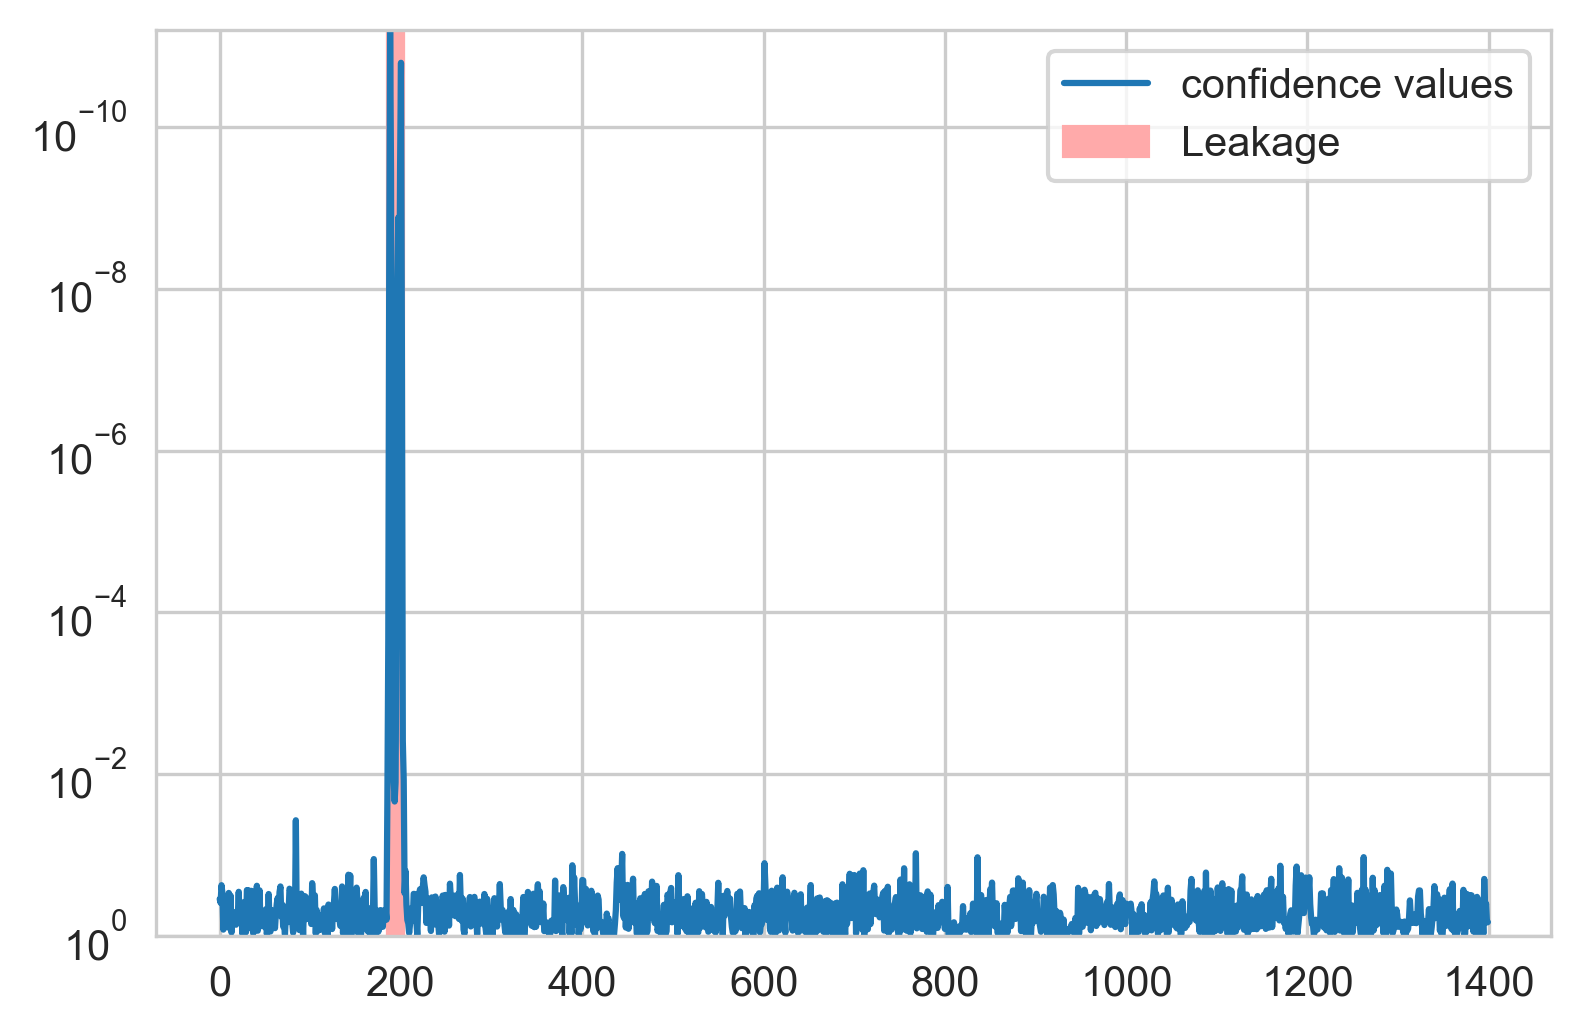

In [7]:
def plot_confidence_values(_, confidence_values):
    for LEAKAGE_IX in np.where(confidence_values < 10 ** -5)[0]:
        plt.axvline(LEAKAGE_IX, color='#faa')

    g = sns.lineplot(data={
        "confidence values": confidence_values,
    })
    g.invert_yaxis()
    g.set(yscale="log", ylim=(1, np.min(confidence_values)))

    handles, labels = g.get_legend_handles_labels()
    patch = mpatches.Patch(color='#faa', label='Leakage')
    handles.append(patch)

    plt.legend(handles=handles)

plot_confidence_values(*tvla_goodwill(X, Y, 2))

In [8]:
def prepare_traces_dlla2(x, y, x_att, y_att, reduction_function):
    x9, y9, x9_att, y9_att = prepare_traces_dl(x, y, x_att, y_att)

    x2, y2 = reduction_function(x9, y9)
    x2_att, y2_att = reduction_function(x9_att, y9_att)

    return x2, y2, x2_att, y2_att

In [9]:
def dlla_wegener(x, y, x_att, y_att, threshold = 10 ** -5):
    model = make_mlp_wegener(x, y, x_att, y_att, False)

    predictions = model.predict(x_att)
    correct = np.array(predictions.argmax(axis=1) == y_att.argmax(axis=1))
    num_correct = np.sum(correct)

    confidence_value = binomial_test(len(predictions), num_correct)
    leakage = confidence_value < threshold

    return leakage, np.array([confidence_value])

# DLLA_WEGENER_RES = dlla_wegener(*prepare_traces_dlla2(TRACES, HW, TRACES_ATT, HW_ATT, reduce_fixed_fixed))

(True, array([2.23461405e-269]))

In [10]:
def make_mlp(x, y, params):
    mdl = Sequential()
    mdl.add(Dense(100, activation=params['activation'], input_shape=(x.shape[1],)))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(9, activation='softmax'))

    mdl.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])

    out = mdl.fit(x, y, shuffle=True, batch_size=params['batch_size'], epochs=params['epochs'], verbose=False)

    return out, mdl

def dlla_specific(x, y, x_att, y_att, threshold = 10 ** -5):
    model = make_mlp(x, y, {
        'activation':'relu',
        'optimizer': Adam(learning_rate=0.001),
        'losses': 'categorical_crossentropy',
        'batch_size': 150,
        'epochs': 5
    })[1]

    confidence_value, _ = dlla_hw(model, x_att, y_att) # FP check confidence value is discarded.
    leakage = confidence_value < threshold

    return leakage, np.array([confidence_value])

dlla_specific(*prepare_traces_dl(TRACES, HW, TRACES_ATT, HW_ATT))

(True, array([3.33949033e-13]))

In [11]:
TEST_P = np.zeros(1000)
TEST_P[:1000] = 1

def binary_search(p_array, total, threshold = 10 ** -5):
    l = 0
    r = total

    while l < r:
        ix = math.floor((l + r) / 2)
        if p_array[ix] > threshold:
            l = ix + 1
        else:
            r = ix

    return l

# binary_search(TEST_P, len(TEST_P)), TEST_P[499]

In [12]:
def limit_trace_ix(x, x_att, ix: int = None):
    """
    Reduces the number of traces in a trace set while maintaining the ratio between
        the number of profiling traces and the number of attack traces.

    Returns the index at which the profiling traces and attack traces need to be sliced, respectively.
    """
    total = len(x) + len(x_att)
    if ix is None or ix > total:
        ix = total

    ratio = len(x) / total

    ix_prof = math.floor(ix * ratio)
    ix_att = math.ceil(ix * (1 - ratio))

    return ix_prof, ix_att

def limit_traces(x, y, x_att, y_att, ix: int = None):
    ix_prof, ix_att = limit_trace_ix(x, x_att, ix)

    return x[:ix_prof], y[:ix_prof], x_att[:ix_att], y_att[:ix_att]

limit_trace_ix(np.arange(2000), np.arange(1000), 100)

(66, 34)

In [13]:
def la(method, traces, hw, traces_att, hw_att, ix: int = None):
    tvla_match = re.match('^tvla_([0-9]+)$', method)

    if tvla_match:
        order = int(tvla_match.group(1))

        traces_all = np.concatenate([traces, traces_att], axis=0)
        hw_all = np.concatenate([hw, hw_att], axis=0)

        x, y = prepare_traces(traces_all[:ix], hw_all[:ix])
        leakage, confidence_values = tvla_goodwill(x, y, order)
    elif method == "dlla_2":
        trc = limit_traces(traces, hw, traces_att, hw_att, ix)

        trc_2cls = prepare_traces_dlla2(*trc, reduce_fixed_fixed)
        leakage, confidence_values = dlla_wegener(*trc_2cls)
    elif method == "dlla_9":
        trc = limit_traces(traces, hw, traces_att, hw_att, ix)

        trc_9cls = prepare_traces_dl(*trc)
        leakage, confidence_values = dlla_specific(*trc_9cls)
    else:
        raise Exception(f"Unknown method: {method}")

    return leakage, confidence_values

def binary_p_search(method, traces, hw, traces_att, hw_att):
    total = len(traces) + len(traces_att)
    print(f"Leakage detection ({method}): {total}/{total}", end='\r')
    leakage, pvs = la(method, traces, hw, traces_att, hw_att)

    l = -1 # Indicates that no leakage was found.
    if leakage:
        l = 0
        r = total

        while l + 3 < r:
            ix = math.floor((l + r) / 2)

            print(f"Leakage boundary search ({method}): {ix}/{total}", end='\r')
            leakage, _ = la(method, traces, hw, traces_att, hw_att, ix)

            if not leakage:
                l = ix + 1
            else:
                r = ix

    print()
    return l, pvs

binary_p_search("dlla_2", TRACES, HW, TRACES_ATT, HW_ATT)
binary_p_search("dlla_9", TRACES, HW, TRACES_ATT, HW_ATT)

Leakage boundary search (dlla_2): 23066/300000
Leakage boundary search (dlla_9): 37387/300000


(37388, array([2.43528629e-11]))

In [14]:
def store_results(method: str, pollution: Union[Pollution,None], traces: int, leakage_boundary: int, confidence_values: np.ndarray):
    f_name = f'results/{method}.csv'
    if not os.path.exists(f_name):
        make_dirs(f_name)

        with open(f_name, 'w') as f:
            f.write("time;pollution;pollution_parameter;traces;leakage_boundary;confidence_value,confidence_values\n")

    with open(f_name, 'a') as f:
        pollution_name, pollution_parameter = "none", 0
        if pollution is not None:
            pollution_name, pollution_parameter = pollution.type.name, pollution.parameter

        f.write(';'.join([
            str(datetime.datetime.today()),
            str(pollution_name),
            str(pollution_parameter),
            str(traces),
            str(leakage_boundary),
            str(np.min(confidence_values)),
            ','.join(confidence_values.astype(str))
        ]))
        f.write('\n')

# store_results("tvla_2", None, 1000, *binary_p_search("tvla_2", TRACES[:1000], HW[:1000], TRACES_ATT[:1000], HW_ATT[:1000]))

In [15]:
def available_pollutions(trace_set: AbstractTraceSet):
    data_dir = os.path.dirname(trace_set.path)
    pollutions = [poll.name for poll in list(PollutionType)]
    res = {}

    for pollution in pollutions:
        files = glob.glob(os.path.join(data_dir, f"{pollution}*.h5"))
        params = np.zeros(len(files))

        for ix, file in enumerate(files):
            param_raw = re.match(f'^{pollution}_(.*)\.h5$', os.path.basename(file)).group(1)
            params[ix] = float(param_raw.replace("-", "."))

        params = np.sort(params)
        res[PollutionType[pollution]] = params

    return res

available_pollutions(TraceSetHW(Database.ascad))

{<PollutionType.jitter: 'jitter'>: array([ 0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ,  2.75,
         3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,  4.5 ,  4.75,  5.  ,
         5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,  7.  ,  7.25,
         7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,  9.25,  9.5 ,
         9.75, 10.  ]),
 <PollutionType.desync: 'desync'>: array([  2.,   4.,   6.,   8.,  10.,  20.,  30.,  40.,  50., 100., 150.,
        200., 250., 300.])}

In [16]:
def read_h5(database: Database, pollution: Pollution = None):
    h5 = TraceSetHW(database, pollution).open('r')
    traces, hw = np.array(h5['profile/traces']), np.array(h5['profile/hw'])
    traces_att, hw_att = np.array(h5['attack/traces']), np.array(h5['attack/hw'])
    h5.close()

    return traces, hw, traces_att, hw_att


def leakage_boundaries(method, database: Database):
    traces, hw, traces_att, hw_att = read_h5(Database.ascad)
    total = len(traces) + len(traces_att)
    store_results(method, None, total, *binary_p_search(method, traces, hw, traces_att, hw_att))

    for pollution_type, params in available_pollutions(TraceSetHW(database)).items():
        for param in params:
            print(f"Computing leakage boundary for {pollution_type.name}({param})")

            pollution = Pollution(pollution_type, param)
            traces, hw, traces_att, hw_att = read_h5(Database.ascad, pollution)
            total = len(traces) + len(traces_att)

            leakage_boundary, pvs = binary_p_search(method, traces, hw, traces_att, hw_att)
            store_results(method, pollution, total, leakage_boundary, pvs)

            if np.min(pvs) > 10 ** -3:
                break

    print("Done.")


# leakage_boundaries("dlla_2", Database.ascad)
# leakage_boundaries("dlla_9", Database.ascad)